<div>
    <img src="https://storage.googleapis.com/kaggle-datasets-images/312305/633246/752964d08f6001573444649668b0b011/dataset-cover.jpg?t=2019-08-22-03-58-44" class="Header_CoverImg-sc-1431b7d ibFJYv">
</div>

In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

import torch
from torch import nn
from functools import reduce

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow
import sys

<h1 id="dataset" style="color:#a97828; background:#4dc5ea;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [2]:
path = '../input/creditcardfraud/creditcard.csv'
df = pd.read_csv(path, sep=",", index_col=None)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Standardize
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

In [4]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape

((492, 31), (284315, 31))

In [5]:
for f in range(0, 20):
    normal = normal.iloc[np.random.permutation(len(normal))]
    

data_set = pd.concat([normal[:2000], anomalies])

x_train, x_test = train_test_split(data_set, test_size = 0.4, random_state = 42)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
314,-1.991803,-1.465381,1.382172,1.019790,0.250367,1.011414,-1.281807,1.186866,-0.312608,-0.701503,...,-0.038147,0.083481,-0.266017,0.270833,0.754353,-0.491529,-0.689819,-0.329374,-0.349231,0
623,-1.986644,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
660,-1.986075,1.255439,0.307729,0.292700,0.699873,-0.428876,-1.088456,0.043840,-0.167739,0.128854,...,-0.294795,-0.882126,0.136846,0.327949,0.194459,0.096516,-0.027271,0.029491,-0.345313,0
995,-1.980769,-0.654892,0.608319,1.585102,-3.009429,0.037593,-1.954023,1.335977,-0.612858,0.690254,...,-0.078527,-0.064194,-0.107350,0.961776,-0.067760,-0.549465,-0.232588,-0.108261,-0.337637,0
1130,-1.978157,-0.801063,1.224553,1.213950,-0.235286,0.262738,-0.199323,0.687000,0.045986,-0.037147,...,-0.305861,-0.529589,0.006725,-0.057861,-0.203208,0.067636,0.302593,-0.011637,-0.317646,0
1318,-1.974809,1.484290,-0.156178,-0.851332,-0.707935,-0.079623,-1.030003,-0.034543,-0.354563,-1.096599,...,0.136015,0.347476,-0.314847,-0.482617,0.927893,0.012160,-0.015183,0.015955,-0.273308,0
1361,-1.974325,-1.441258,0.674872,2.685483,0.243826,-0.558726,0.764201,0.143656,0.054985,1.554454,...,-0.357498,-0.051798,-0.462233,-0.029358,0.418554,0.362262,-0.432949,-0.531989,-0.224731,0
1619,-1.970134,1.350757,-0.332866,0.001453,-0.594763,-0.684586,-0.827280,-0.482697,-0.221653,-0.862776,...,0.050748,0.038799,-0.110279,-0.169617,0.452921,-0.259139,0.028261,0.049768,-0.153725,0
1654,-1.969629,-1.376445,1.614006,0.699273,0.021092,-0.792064,-1.030669,-0.022974,0.810584,-0.482901,...,-0.180650,-0.675246,0.084872,0.354099,-0.111750,0.081781,0.138413,0.030719,-0.281304,0
1664,-1.969397,-1.120905,-0.483700,2.574720,0.231856,0.573274,1.416503,-0.276340,0.559585,0.452086,...,0.171236,0.684320,0.244240,-0.607268,-0.621754,0.348224,-0.020175,-0.092693,-0.094593,0


In [6]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1])
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1])
input_shape = (x_train.shape[1], 1)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1495, 31)
y_train:(1495, 2)

x_test:(997, 31)
y_test:(997, 2)

input_shape:(31, 1)



<h1 id="tree" style="color:#a97828; background:#4dc5ea;"> 
    <center>Decision Tree
        <a class="anchor-link" href="#tree" target="_self">¶</a>
    </center>
</h1>

In [7]:
class Tree():
    def __init__(self):
        self.num_cut = [1, 1]
        self.num_leaf = np.prod(np.array(self.num_cut) + 1)
        self.num_class = 2
        
    def torch_kron_prod(self, a, b):
        res = torch.einsum('ij,ik->ijk', [a, b])
        res = torch.reshape(res, [-1, np.prod(res.shape[1:])])
        return res
    
    def torch_bin(self, x, cut_points, temperature=0.1):
        D = cut_points.shape[0]
        W = torch.reshape(torch.linspace(1.0, D + 1.0, D + 1), [1, -1])
        cut_points, _ = torch.sort(cut_points)
        b = torch.cumsum(torch.cat([torch.zeros([1]), -cut_points], 0),0)
        h = torch.matmul(x, W) + b
        res = torch.exp(h-torch.max(h))
        res = res/torch.sum(res, dim=-1, keepdim=True)
        return h
    
    def nn_decision_tree(self, x, cut_points_list, leaf_score, temperature=0.1):
        leaf = reduce(self.torch_kron_prod,
                      map(lambda z: self.torch_bin(x[:, z[0]:z[0] + 1], z[1], temperature), enumerate(cut_points_list)))
        return torch.matmul(leaf, leaf_score)

In [8]:
tree = Tree()

cut_points_list = [torch.rand([i], requires_grad=True) for i in tree.num_cut]
leaf_score = torch.rand([tree.num_leaf, tree.num_class], requires_grad=True)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cut_points_list + [leaf_score], lr=0.001, weight_decay=0.001)

In [9]:
model = nn.Sequential(
          nn.Linear(31,16),
          nn.ReLU(),
          nn.Linear(16,8),
          nn.ReLU(),
          nn.Linear(8,2),
          nn.Sigmoid()
        )

<h1 id="training" style="color:#a97828; background:#4dc5ea;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [10]:
for i in range(300):
    optimizer.zero_grad()
    x_batches = torch.split(torch.tensor(x_train).type(torch.float32), 32)
    y_batches = torch.split(torch.tensor(y_train).type(torch.long), 32)
    
    losses = torch.zeros(len(x_batches))
    accs = torch.zeros(len(x_batches))
    for j,x in enumerate(x_batches):
        out = model(x)
        y_pred = tree.nn_decision_tree(out, cut_points_list, 
                                       leaf_score, temperature=0.1)
        y_max = torch.max(y_batches[j], axis=1)[1]
        y_pred_max = torch.max(y_pred, axis=1)[1]
        
        acc = len(torch.where(y_max == y_pred_max)[0]) / len(y_max)
        accs[j] = acc
        
        loss = loss_function(y_pred, y_max)
        losses[j] = loss
        
        loss.backward()
        optimizer.step()
    if((i+1) % 20 == 0):
        print("i:{:4d}, loss:{:1.3f}, acc:{:1.3f}".format(i+1, losses.mean(), accs.mean()))

i:  20, loss:0.509, acc:0.804
i:  40, loss:0.506, acc:0.804
i:  60, loss:0.503, acc:0.804
i:  80, loss:0.501, acc:0.804
i: 100, loss:0.498, acc:0.807
i: 120, loss:0.497, acc:0.812
i: 140, loss:0.497, acc:0.814
i: 160, loss:0.497, acc:0.816
i: 180, loss:0.496, acc:0.816
i: 200, loss:0.495, acc:0.816
i: 220, loss:0.494, acc:0.815
i: 240, loss:0.494, acc:0.815
i: 260, loss:0.493, acc:0.815
i: 280, loss:0.492, acc:0.815
i: 300, loss:0.492, acc:0.815


<h1 id="prediction" style="color:#a97828; background:#4dc5ea;"> 
    <center>Prediction
        <a class="anchor-link" href="#prediction" target="_self">¶</a>
    </center>
</h1>

In [11]:
def predict(tree, X, y):
    X = torch.tensor(X).type(torch.float32)
    y = torch.tensor(y).type(torch.long)

    out = model(X)
    y_pred = tree.nn_decision_tree(out, cut_points_list, leaf_score, temperature=0.1)
    y_max = torch.max(y, axis=1)[1]
    y_pred_max = torch.max(y_pred, axis=1)[1]

    acc = len(torch.where(y_max == y_pred_max)[0]) / len(y_max)
    loss = loss_function(y_pred, y_max)
    return y_pred, acc, loss

In [12]:
y_pred, acc, loss = predict(tree, x_test, y_test)
print("Accuracy:{:1.3f}, Loss:{:1.3f}"
         .format(acc, loss))

Accuracy:0.807, Loss:0.514


<h1 id="visualization" style="color:#a97828; background:#4dc5ea;"> 
    <center>Visaulization
        <a class="anchor-link" href="#visualization" target="_self">¶</a>
    </center>
</h1>

In [13]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

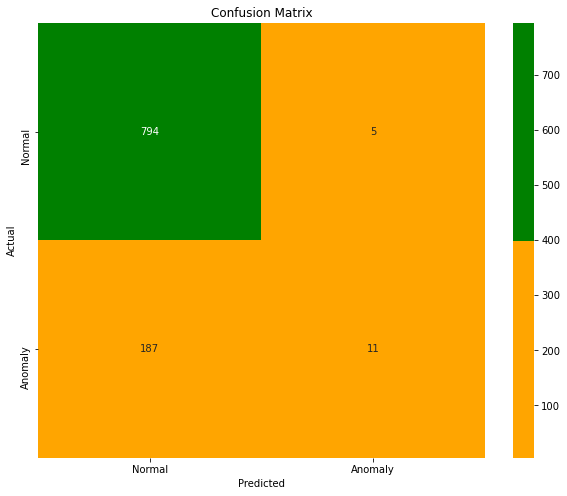

In [14]:
visualize = Visualization()
y_pred2 = torch.max(y_pred, axis=1)[1].detach().numpy()
y_test2 = np.argmax(y_test, axis=1)
visualize.draw_confusion_matrix(y_test2, y_pred2)